In [1]:
from pyspark.sql.functions import *
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
%matplotlib inline

In [2]:
GDP_dataset = 'Spark_Dataset/GDP/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10134290/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10134290.csv'
HDI_dataset = 'Spark_Dataset/HDI/Human Development Index (HDI).csv'
Infant_Mortality_dataset = 'Spark_Dataset/Infant_Mortality_Rate/API_SP.DYN.IMRT.IN_DS2_en_csv_v2_10181276/API_SP.DYN.IMRT.IN_DS2_en_csv_v2_10181276.csv'
Life_Expectancy_dataset = 'Spark_Dataset/Life_Expectancy/API_SP.DYN.LE00.IN_DS2_en_csv_v2_10181296/API_SP.DYN.LE00.IN_DS2_en_csv_v2_10181296.csv'

In [3]:
def developed_countries_list():
    dc_list = []
    dc_list.append("Australia")
    dc_list.append("Austria")
    dc_list.append("Belgium")
    dc_list.append("Canada")
    dc_list.append("Cyprus")
    dc_list.append("Czech Republic")
    dc_list.append("Denmark")
    dc_list.append("Finland")
    dc_list.append("France")
    dc_list.append("Germany")
    dc_list.append("Greece")
    #dc_list.append("Hong Kong SAR, China")
    dc_list.append("Iceland")
    dc_list.append("Ireland")
    dc_list.append("Israel")
    dc_list.append("Italy")
    dc_list.append("Japan")
    #dc_list.append("Korea, Rep.")
    dc_list.append("Luxembourg")
    dc_list.append("Malta")
    dc_list.append("Netherlands")
    dc_list.append("New Zealand")
    dc_list.append("Norway")
    dc_list.append("Portugal")
    dc_list.append("Singapore")
    dc_list.append("Slovak Republic")
    dc_list.append("Slovenia")
    dc_list.append("Spain")
    dc_list.append("Sweden")
    dc_list.append("Switzerland")
    #dc_list.append("Taiwan")
    dc_list.append("United Kingdom")
    dc_list.append("United States")
    return dc_list

In [4]:
def addColumnIndex(df): 
    oldColumns = df.schema.names
    newColumns = oldColumns + ["columnindex"]
    df_indexed = df.rdd.zipWithIndex().map(lambda (row, columnindex): \
                                         row + (columnindex,)).toDF(newColumns)   
    return df_indexed

In [5]:
gdp_df = spark.read.option('header','true').option('sep', '\t').option('inferSchema','true').csv(GDP_dataset)
hdi_df = spark.read.option('header','true').option('inferSchema','true').csv(HDI_dataset)
im_df = spark.read.option('header','true').option('sep', '\t').option('inferSchema','true').csv(Infant_Mortality_dataset)
le_df = spark.read.option('header','true').option('sep', '\t').option('inferSchema','true').csv(Life_Expectancy_dataset)

In [6]:
hdi_drop_col = []
for i in range(3,len(hdi_df.schema.names)):
    if(i%2 == 1):
        hdi_drop_col.append(hdi_df.schema.names[i])
hdi_df = hdi_df.withColumn('Country', ltrim(hdi_df.Country))
hdi_df = hdi_df.select([column for column in hdi_df.columns if column not in hdi_drop_col])
hdi_df = hdi_df.withColumn('Country', regexp_replace('Country', 'Czechia', 'Czech Republic'))
#hdi_df = hdi_df.withColumn('Country', regexp_replace('Country', 'Hong Kong, China (SAR)', 'Hong Kong SAR, China'))
#hdi_df = hdi_df.withColumn('Country', regexp_replace('Country', 'Korea (Republic of)', 'Korea, Rep.'))
hdi_df = hdi_df.withColumn('Country', regexp_replace('Country', 'Slovakia', 'Slovak Republic'))

In [7]:
# Get the list of all developed countries   
countries_list = developed_countries_list()
# Add India among other countries for comparison and analysis
countries_list.append("India")

In [8]:
developed_gdp_df = gdp_df.filter(col('Country Name').isin(countries_list))
developed_im_df = im_df.filter(col('Country Name').isin(countries_list))
developed_le_df = le_df.filter(col('Country Name').isin(countries_list))
developed_hdi_df = hdi_df.filter(col('Country').isin(countries_list))

In [9]:
drop_cols_n = range(1960,1995)
drop_cols_n.append(2017)
drop_cols_s = [str(i) for i in drop_cols_n]

In [10]:
developed_gdp_df = developed_gdp_df.select([column for column in developed_gdp_df.columns if column not in drop_cols_s])
developed_gdp_df = developed_gdp_df.select([column for column in developed_gdp_df.columns if column not in ['Country Code','Indicator Name','Indicator Code']])

# Grad data from first columns, since it will be transposed to new column headers
new_header = [i[0]+str(1) for i in developed_gdp_df.select("Country Name").rdd.map(tuple).collect()]

# Remove first column from dataframe
developed_gdp_df2 = developed_gdp_df.select([c for c in developed_gdp_df.columns if c not in ['Country Name']])

# Convert DataFrame to RDD
developed_gdp_rdd = developed_gdp_df2.rdd.map(tuple)

# Transpose Data
developed_gdp_rddT1 = developed_gdp_rdd.zipWithIndex().flatMap(lambda (x,i): [(i,j,e) for (j,e) in enumerate(x)])
developed_gdp_rddT2 = developed_gdp_rddT1.map(lambda (i,j,e): (j, (i,e))).groupByKey().sortByKey()
developed_gdp_rddT3 = developed_gdp_rddT2.map(lambda (i, x): sorted(list(x), cmp=lambda (i1,e1),(i2,e2) : cmp(i1, i2)))
developed_gdp_rddT4 = developed_gdp_rddT3.map(lambda x: map(lambda (i, y): y , x))

# Convert back to DataFrame (along with header)
developed_gdp_transposed_df = developed_gdp_rddT4.toDF(new_header)

#Normalize the columns
for field in developed_gdp_transposed_df.schema.fields:
    if str(field.dataType) in ['DoubleType', 'FloatType', 'LongType', 'IntegerType', 'DecimalType']:
        name = str(field.name)
        divider = developed_gdp_transposed_df.agg({name: "max"}).collect()[0][0]
        #developed_gdp_transposed_df.groupBy().sum().collect()[0]["sum("+name+")"]
        developed_gdp_transposed_df = developed_gdp_transposed_df.withColumn(name, col(name)/divider)

In [11]:
developed_im_df = developed_im_df.select([column for column in developed_im_df.columns if column not in drop_cols_s])
developed_im_df = developed_im_df.select([column for column in developed_im_df.columns if column not in ['Country Code','Indicator Name','Indicator Code']])

# Grad data from first columns, since it will be transposed to new column headers
new_header = [i[0]+str(2) for i in developed_im_df.select("Country Name").rdd.map(tuple).collect()]

# Remove first column from dataframe
developed_im_df2 = developed_im_df.select([c for c in developed_im_df.columns if c not in ['Country Name']])

# Convert DataFrame to RDD
developed_im_rdd = developed_im_df2.rdd.map(tuple)

# Transpose Data
developed_im_rddT1 = developed_im_rdd.zipWithIndex().flatMap(lambda (x,i): [(i,j,e) for (j,e) in enumerate(x)])
developed_im_rddT2 = developed_im_rddT1.map(lambda (i,j,e): (j, (i,e))).groupByKey().sortByKey()
developed_im_rddT3 = developed_im_rddT2.map(lambda (i, x): sorted(list(x), cmp=lambda (i1,e1),(i2,e2) : cmp(i1, i2)))
developed_im_rddT4 = developed_im_rddT3.map(lambda x: map(lambda (i, y): y , x))

# Convert back to DataFrame (along with header)
developed_im_transposed_df = developed_im_rddT4.toDF(new_header)

#Normalize the columns
for field in developed_im_transposed_df.schema.fields:
    if str(field.dataType) in ['DoubleType', 'FloatType', 'LongType', 'IntegerType', 'DecimalType']:
        name = str(field.name)
        divider = developed_im_transposed_df.agg({name: "max"}).collect()[0][0]
        #developed_im_transposed_df.groupBy().sum().collect()[0]["sum("+name+")"]
        developed_im_transposed_df = developed_im_transposed_df.withColumn(name, col(name)/divider)

In [12]:
developed_le_df = developed_le_df.select([column for column in developed_le_df.columns if column not in drop_cols_s])
developed_le_df = developed_le_df.select([column for column in developed_le_df.columns if column not in ['Country Code','Indicator Name','Indicator Code']])

# Grad data from first columns, since it will be transposed to new column headers
new_header = [i[0]+str(3) for i in developed_le_df.select("Country Name").rdd.map(tuple).collect()]

# Remove first column from dataframe
developed_le_df2 = developed_le_df.select([c for c in developed_le_df.columns if c not in ['Country Name']])

# Convert DataFrame to RDD
developed_le_rdd = developed_le_df2.rdd.map(tuple)

# Transpose Data
developed_le_rddT1 = developed_le_rdd.zipWithIndex().flatMap(lambda (x,i): [(i,j,e) for (j,e) in enumerate(x)])
developed_le_rddT2 = developed_le_rddT1.map(lambda (i,j,e): (j, (i,e))).groupByKey().sortByKey()
developed_le_rddT3 = developed_le_rddT2.map(lambda (i, x): sorted(list(x), cmp=lambda (i1,e1),(i2,e2) : cmp(i1, i2)))
developed_le_rddT4 = developed_le_rddT3.map(lambda x: map(lambda (i, y): y , x))

# Convert back to DataFrame (along with header)
developed_le_transposed_df = developed_le_rddT4.toDF(new_header)

#Normalize the columns
for field in developed_le_transposed_df.schema.fields:
    if str(field.dataType) in ['DoubleType', 'FloatType', 'LongType', 'IntegerType', 'DecimalType']:
        name = str(field.name)
        divider = developed_le_transposed_df.agg({name: "max"}).collect()[0][0]
        #developed_le_transposed_df.groupBy().sum().collect()[0]["sum("+name+")"]
        developed_le_transposed_df = developed_le_transposed_df.withColumn(name, col(name)/divider)

In [13]:
developed_hdi_df = developed_hdi_df.select([column for column in developed_hdi_df.columns if column not in drop_cols_s])
developed_hdi_df = developed_hdi_df.select([column for column in developed_hdi_df.columns if column not in ['HDI Rank (2017)']])

# Grad data from first columns, since it will be transposed to new column headers
new_header = [i[0]+str(4) for i in developed_hdi_df.select("Country").rdd.map(tuple).collect()]

# Remove first column from dataframe
developed_hdi_df2 = developed_hdi_df.select([c for c in developed_hdi_df.columns if c not in ['Country']])

# Convert DataFrame to RDD
developed_hdi_rdd = developed_hdi_df2.rdd.map(tuple)

# Transpose Data
developed_hdi_rddT1 = developed_hdi_rdd.zipWithIndex().flatMap(lambda (x,i): [(i,j,e) for (j,e) in enumerate(x)])
developed_hdi_rddT2 = developed_hdi_rddT1.map(lambda (i,j,e): (j, (i,e))).groupByKey().sortByKey()
developed_hdi_rddT3 = developed_hdi_rddT2.map(lambda (i, x): sorted(list(x), cmp=lambda (i1,e1),(i2,e2) : cmp(i1, i2)))
developed_hdi_rddT4 = developed_hdi_rddT3.map(lambda x: map(lambda (i, y): y , x))

# Convert back to DataFrame (along with header)
developed_hdi_transposed_df = developed_hdi_rddT4.toDF(new_header)

#Normalize the columns
for field in developed_hdi_transposed_df.schema.fields:
    if str(field.dataType) in ['DoubleType', 'FloatType', 'LongType', 'IntegerType', 'DecimalType']:
        name = str(field.name)
        divider = developed_hdi_transposed_df.agg({name: "max"}).collect()[0][0]
        #developed_gdp_transposed_df.groupBy().sum().collect()[0]["sum("+name+")"]
        developed_hdi_transposed_df = developed_hdi_transposed_df.withColumn(name, col(name)/divider)

In [14]:
developed_gdp_transposed_df_WithIndex = addColumnIndex(developed_gdp_transposed_df)
developed_le_transposed_df_WithIndex = addColumnIndex(developed_le_transposed_df)
developed_im_transposed_df_WithIndex = addColumnIndex(developed_im_transposed_df)
developed_hdi_transposed_df_WithIndex = addColumnIndex(developed_hdi_transposed_df)

In [15]:
merge_1 = developed_gdp_transposed_df_WithIndex.join(developed_le_transposed_df_WithIndex, ("columnindex"),
                           'inner').drop("columnindex")
merge_2 = developed_im_transposed_df_WithIndex.join(developed_hdi_transposed_df_WithIndex, ("columnindex"),
                           'inner').drop("columnindex")
merge_1_Index = addColumnIndex(merge_1)
merge_2_Index = addColumnIndex(merge_2)

In [16]:
new_header = [i[0] for i in developed_hdi_df.select("Country").rdd.map(tuple).collect()]

In [17]:
grand_df_countries = merge_1_Index.join(merge_2_Index, ("columnindex"),
                           'inner').drop("columnindex")

for country in new_header:
    grand_df_countries = grand_df_countries.withColumn(country, (5*grand_df_countries[(country+str(1))] + 2*grand_df_countries[(country+str(2))] + 2*grand_df_countries[(country+str(3))] + grand_df_countries[(country+str(4))])/10)
    
grand_df_countries = grand_df_countries.select([column for column in grand_df_countries.columns if column in new_header])

In [23]:
final_gdp_pd_df = developed_gdp_transposed_df.toPandas()
final_gdp_pd_df.index = range(1995,2017)

final_im_pd_df = developed_im_transposed_df.toPandas()
final_im_pd_df.index = range(1995,2017)

final_le_pd_df = developed_le_transposed_df.toPandas()
final_le_pd_df.index = range(1995,2017)

final_hdi_pd_df = developed_hdi_transposed_df.toPandas()
final_hdi_pd_df.index = range(1995,2017)

In [18]:
final_pd_df = grand_df_countries.toPandas()
final_pd_df.index = range(1995,2017)

<Figure size 720x720 with 0 Axes>

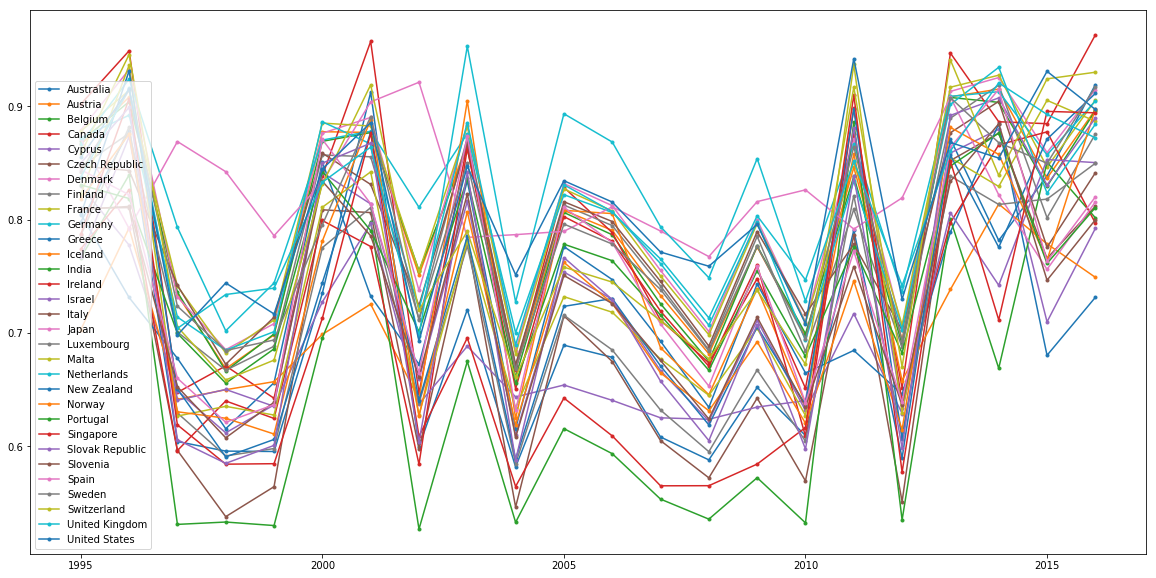

In [20]:
plt.figure(figsize=(10,10))
final_pd_df.plot(figsize=(20,10),style='.-');
plt.show()

<Figure size 720x720 with 0 Axes>

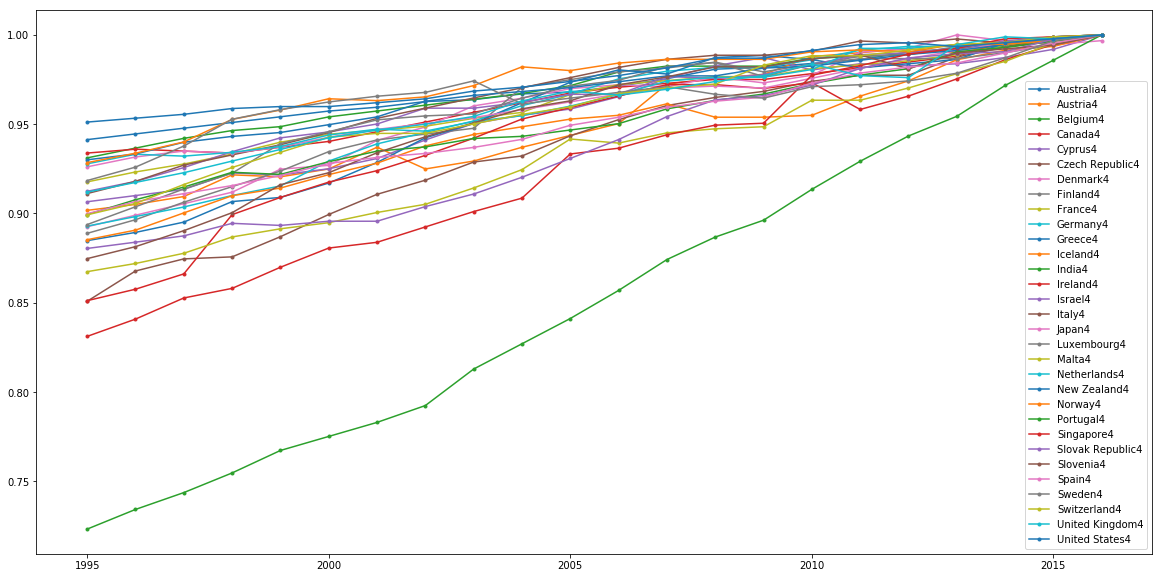

In [27]:
plt.figure(figsize=(10,10))
final_hdi_pd_df.plot(figsize=(20,10),style='.-');
plt.show()

In [38]:
final_hdi_pd_df[['India4']]

,India4
1995,0.723270
1996,0.734277
1997,0.743711
1998,0.754717
1999,0.767296
2000,0.775157
2001,0.783019
2002,0.792453
2003,0.812893
2004,0.827044
